# DCGAN: Anime Face Generator

## Importing Necessary Libraries

In [17]:
import os, cv2, torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image, make_grid


I'm importing the necessary libraries for my PyTorch project. Here's a breakdown of what each import statement does:

- `os`: Allows me to interact with the operating system, such as handling file paths.
- `cv2`: Provides computer vision functionalities, which might be useful for image processing tasks.
- `torch`: The core PyTorch library.
- `numpy`: A library for numerical operations in Python, commonly used alongside PyTorch.
- `matplotlib.pyplot`: Enables me to visualize data, such as plotting graphs and images.
- `torchvision.transforms as tt`: The `transforms` module from torchvision, which helps me perform various image transformations.
- `torch.nn as nn`: PyTorch's neural network module, providing tools to build and train neural networks.
- `torch.nn.functional as F`: The functional interface to operations in `torch.nn`.
- `tqdm`: A library that creates progress bars, making it easier to monitor long-running tasks.
- `torch.utils.data.DataLoader`: Used for loading data efficiently, creating batches, and shuffling.
- `torchvision.datasets.ImageFolder`: A dataset class that loads images from a directory structure.
- `torchvision.utils.save_image` and `torchvision.utils.make_grid`: Utility functions for saving images and creating grid displays.

Overall, these libraries cover file handling, image processing, neural network construction, and data loading.

Keep in mind that the specific functionalities of these libraries will be used as I progress through my PyTorch project.


## Dataset Description

The Anime Face Dataset comprises 21,551 anime faces sourced from www.getchu.com. - All images in the dataset SHOULD BE resized manually to a standard size of 64 x 64 pixels. This ensures uniformity and simplifies the training process for the neural network.

## Data Preprocessing and Loading

In [59]:
# CONSTANTS
IMAGE_SIZE = 64
BATCH_SIZE = 128
MEAN, STD = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DATA_DIR = './data/'

In [60]:
train_ds = ImageFolder(DATA_DIR, transform = tt.Compose([tt.Resize(IMAGE_SIZE),
                                                         tt.CenterCrop(IMAGE_SIZE),
                                                         tt.ToTensor(),
                                                         tt.Normalize(mean=MEAN,
                                                                      std=STD)]))

In [61]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle = True, 
                      num_workers = 2, pin_memory = True)

In [62]:
def denorm(img_tensors):
    return img_tensors * MEAN[0] + STD[0]

In [66]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))


In [67]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

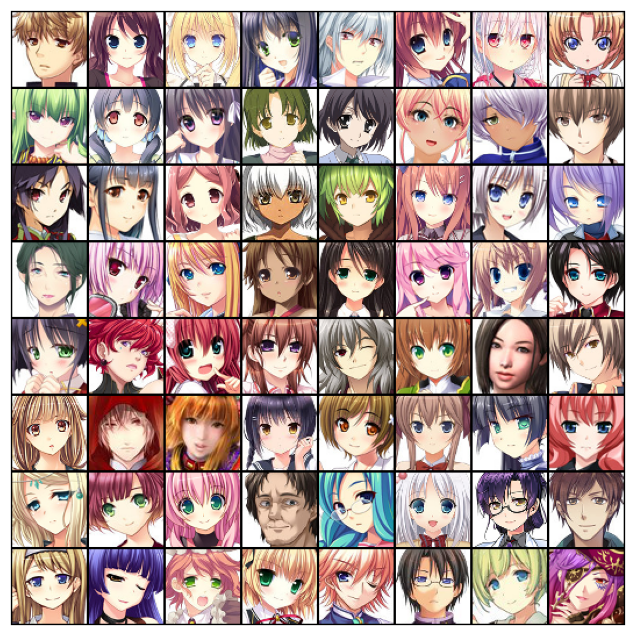

In [68]:
show_batch(train_dl)


I've defined some constants and implemented a simple data loading and visualization pipeline using PyTorch. Here's a breakdown of the code:
#
### Constants:
I've set up some constants to control the behavior of my data processing and loading pipeline:
- `IMAGE_SIZE`: Specifies the size to which images should be resized.
- `BATCH_SIZE`: Defines the number of images in each batch during training.
- `MEAN` and `STD`: These represent the mean and standard deviation used for normalizing the image data.
- `DATA_DIR`: The directory path where my dataset is loca#ted.

### Data Transformation and Loading:
I'm using the `ImageFolder` class from torchvision to load the dataset. The `tt.Compose` function is used to chain together a series of image transformations:
- `tt.Resize`: Resizes the image to the specified size.
- `tt.CenterCrop`: Performs a center crop on the resized image.
- `tt.ToTensor`: Converts the image to a PyTorch tensor.
- `tt.Normalize`: Normalizes the image tensor using the specified mean and standard deviation.

The `train_dl` DataLoader is then created to efficiently load and iterate over batches of data during training. I've used `pin_memory=True` to enable faster data transfer to the GPU if it#'s available.

### Additional Functions for Visualization:
I've defined two additional functions:
- `denorm`: Reverts the normalization, allowing me to display the original images.
- `show_images`: Takes a batch of image tensors, denormalizes them, and displays them in a grid.
- `show_batch`: Takes a DataLoader and displays a batch of images using the `show_images` function.

Finally, I call `show_batch(train_dl)` to visualize a batch of training images.

This code provides a solid foundation for loading, transforming, and visualizing image data in the context of a PyTorch project.

## Transferring Data to the GPU Device

In [69]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [70]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [71]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [72]:
train_dl = DeviceDataLoader(train_dl, device)

In this code, I've defined a utility function `to_device` and a custom class `DeviceDataLoader` to facilitate data movement between CPU and GPU. Here's an explanation using first-person perspective:

#### `to_device` Function:
I've created a utility function called `to_device` that helps me move data to the specified device (CPU or GPU). This is particularly useful when dealing with PyTorch tensors. Here's how it works:

- If the input data is a list or tuple, I recursively apply the `to_device` function to each element within the list or tuple.
- For individual data items (not a list or tuple), I use the `.to(device, non_blocking=True)` method to move the data to the specified device. The `non_blocking=True` argument is used for asynchronous data transfer when using CUDA (GPU).

#### `DeviceDataLoader` Class:
I've created a custom data loader class, `DeviceDataLoader`, which wraps around an existing data loader (`dl`) and ensures that each batch of data is moved to the specified device. Here's how it's structured:

- The `__init__` method initializes the `DeviceDataLoader` with the provided data loader (`dl`) and the target device.
- The `__iter__` method is implemented to iterate through batches of data from the original data loader (`dl`). For each batch, it yields the batch after applying the `to_device` function to move it to the specified device.
- The `__len__` method returns the length of the original data loader.

#### Setting the Device and Creating the Device DataLoader:
I determine whether to use the CPU or GPU based on the availability of a CUDA-enabled device. I then create a PyTorch device (`torch.device`) accordingly.

Finally, I instantiate the `DeviceDataLoader` class, passing the original `train_dl` and the chosen device. This ensures that during training, the batches of data are efficiently moved to the specified device, allowing for faster computation, especially on a GPU.

This code is a useful abstraction for handling device-specific data movement and is a common practice when working with PyTorch on different hardware.

## Discriminator Neural Network

In [106]:
# Define the discriminator architecture using nn.Sequential
discriminator = nn.Sequential(
    # First Convolutional Layer
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # Second Convolutional Layer
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # Third Convolutional Layer
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # Fourth Convolutional Layer
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # Fifth Convolutional Layer (Output Layer)
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)


In [102]:
discriminator = to_device(discriminator, device)
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [76]:
LATENT_SIZE = 128

I'm defining the architecture for the discriminator in my DCGAN (Deep Convolutional Generative Adversarial Network) project using PyTorch. This neural network plays a crucial role in distinguishing between real and generated anime faces. Here's a breakdown of the code:

#### Discriminator Architecture:
- I've organized the layers in a sequential manner using `nn.Sequential`.
- The first convolutional layer takes input channels of 3 (for RGB images) and outputs 64 channels. It uses a kernel size of 4, a stride of 2, and a Leaky ReLU activation with a negative slope of 0.2.
- Batch normalization is applied after each convolutional layer to stabilize and accelerate the training process.
- I've progressively increased the number of channels through subsequent layers: 64 to 128, and then 128 to 512.
- The final convolutional layer reduces the number of channels to 1, effectively producing a single-channel output that represents the discriminator's decision.
- The `nn.Flatten()` layer reshapes the output tensor into a 1D vector.
- A sigmoid activation function is applied to squash the output to the range [0, 1], representing the probability of the input being a real image.

#### Device Placement:
- I ensure that the discriminator is placed on the chosen device (CPU or GPU) using the `to_device` function. This function helps facilitate seamless data movement between the model and the device.

#### Latent Size:
- I've set the `LATENT_SIZE` constant to 128, which represents the size of the latent space. This latent vector serves as the input to the generator in the DCGAN.

In summary, this discriminator architecture is designed to take in images and output a probability indicating whether the input is a real or generated anime face. The Leaky ReLU activations and batch normalization layers contribute to the stability and efficiency of the training process. The discriminator is ready to be trained alongside the generator in my DCGAN project.

## Generator Neural Network

In [86]:
# Define the generator architecture using nn.Sequential
generator = nn.Sequential(
    # First Transposed Convolutional Layer
    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),         # Batch Normalization for stabilization
    nn.ReLU(True),               # ReLU activation function for non-linearity

    # Second Transposed Convolutional Layer
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # Third Transposed Convolutional Layer
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # Fourth Transposed Convolutional Layer
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    # Fifth Transposed Convolutional Layer (Output Layer)
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()                    # Tanh activation for output normalization
)


In [104]:
generator = to_device(generator, device)
summary(generator, input_size=(LATENT_SIZE, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

I'm defining the architecture for the generator in my DCGAN project using PyTorch. This neural network is responsible for generating synthetic anime faces. Let me break down the code for you:

#### Generator Architecture:
I've structured the generator using `nn.Sequential`, composing it with several transposed convolutional layers:

- **First Layer:**
  - Transposed convolution with `LATENT_SIZE` input channels and 512 output channels.
  - Batch normalization is applied to stabilize and accelerate training.
  - ReLU activation function is applied to introduce non-linearity.

- **Second Layer:**
  - Transposed convolution with 512 input channels and 256 output channels.
  - Batch normalization and ReLU activation function are applied similarly.

- **Third Layer:**
  - Transposed convolution with 256 input channels and 128 output channels.
  - Batch normalization and ReLU activation function follow.

- **Fourth Layer:**
  - Transposed convolution with 128 input channels and 64 output channels.
  - Batch normalization and ReLU activation function are used.

- **Fifth Layer:**
  - Transposed convolution with 64 input channels and 3 output channels (for RGB images).
  - The Tanh activation function is applied to squash the output to the range [-1, 1].

#### Device Placement:
I'm ensuring that the generator is placed on the chosen device (CPU or GPU) using the `to_device` function. This function helps seamlessly move the model to the desired device.

#### Overall:
This generator is designed to take a latent vector as input and produce synthetic anime faces. The transposed convolutional layers are crucial for transforming the latent vector into a spatial representation that resembles the distribution of real anime faces. The batch normalization and ReLU activations enhance the stability and expressiveness of the generator.

This generator, in conjunction with the discriminator, forms the core of my DCGAN project, aiming to generate realistic anime faces.

## Initiating to save the generated images

In [88]:
# Generate a batch of random latent vectors
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)

# Generate fake images using the generator
fake_images = generator(xb)

In [89]:
# Print the shape of the generated fake images
print(fake_images.shape)

torch.Size([128, 3, 64, 64])

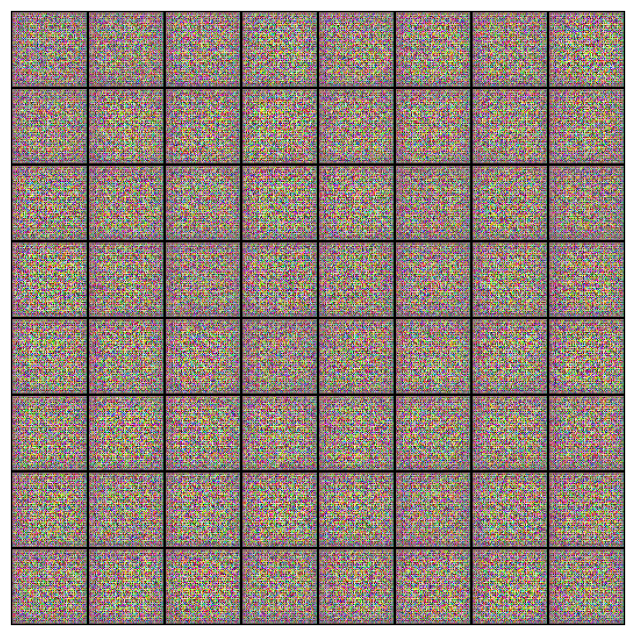

In [90]:
# Show the generated fake images
show_images(fake_images)

In [91]:
# Create a directory to save the generated images
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [92]:
# Generate a fixed set of random latent vectors for consistent visualization
fixed_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)

In [93]:
# Define a function to save generated samples to the specified directory
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = f'generated-images-{index:0=4d}.png'
    
    # Save the generated images
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    # Optionally, display the saved images in a grid
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In this section of my DCGAN project, I am performing various operations related to the generation and visualization of synthetic images. Let me describe each step in detail:

1. **Generate Random Latent Vectors:**
   - I start by generating a batch of random latent vectors (`xb`) using a normal distribution with shape `(BATCH_SIZE, LATENT_SIZE, 1, 1)`.

2. **Generate Fake Images:**
   - Utilizing the generator network, I transform the random latent vectors (`xb`) into synthetic images (`fake_images`).

3. **Inspect the Shape of Generated Images:**
   - I print the shape of the generated fake images to have a quick overview of the dimensions.

4. **Show Generated Images:**
   - Using a visualization function (`show_images`), I display the generated fake images for a visual inspection.

5. **Create a Directory for Saving Generated Samples:**
   - I prepare a directory named 'generated' to save the generated images. If the directory already exists, it ensures that the code doesn't raise an error.

6. **Generate Fixed Latent Vectors for Consistency:**
   - I create a fixed set of random latent vectors (`fixed_latent`) to maintain consistency in the visualization of generated samples.

7. **Define a Function to Save and Display Samples:**
   - I define a function (`save_samples`) responsible for saving generated images with a specific naming convention in the 'generated' directory.
   - Optionally, the function can display the saved images in a grid format using matplotlib.

8. **Save and Display Generated Samples:**
   - I call the `save_samples` function to save generated images using the fixed latent vectors and display them if needed.
   - This step aids in monitoring the quality and progression of generated samples during the training process.

In essence, these steps collectively contribute to the exploration, visualization, and consistent storage of synthetic images generated by the DCGAN model.

## Training the DCGAN

In [112]:
# Define a function to train a GAN model for a specified number of epochs
def fit(model, criterion, epochs, lr, start_idx=1):
    # Set discriminator and generator models to training mode
    model['discriminator'].train()
    model['generator'].train()

    # Clear GPU memory to avoid memory issues during training
    torch.cuda.empty_cache()

    # Initialize lists to store losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Set up separate Adam optimizers for the discriminator and generator networks
    optimizer = {
        'discriminator': torch.optim.Adam(model['discriminator'].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        'generator': torch.optim.Adam(model['generator'].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    # Iterate over the specified number of epochs
    for epoch in range(epochs):
        # Initialize lists to store losses and scores for each batch in the epoch
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        # Iterate over batches in the training data loader
        for real_images, _ in tqdm(train_dl):
            # Zero out gradients for the discriminator optimizer
            optimizer['discriminator'].zero_grad()

            # Forward pass for real images through the discriminator
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images using the generator
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
            fake_images = model['generator'](latent)

            # Forward pass for fake images through the discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            # Append scores to lists
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Calculate and backpropagate the total discriminator loss
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer['discriminator'].step()
            loss_d_per_epoch.append(loss_d.item())

            # Zero out gradients for the generator optimizer
            optimizer['generator'].zero_grad()

            # Generate new fake images and calculate generator loss
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
            fake_images = model['generator'](latent)
            preds = model['discriminator'](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=device)
            loss_g = criterion['generator'](preds, targets)

            # Backpropagate and optimize the generator's parameters
            loss_g.backward()
            optimizer['generator'].step()
            loss_g_per_epoch.append(loss_g.item())

        # Store the average losses and scores for the epoch
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores for the last batch in each epoch
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"loss_g: {losses_g[-1]:.4f}, "
              f"loss_d: {losses_d[-1]:.4f}, "
              f"real_score: {real_scores[-1]:.4f}, "
              f"fake_score: {fake_scores[-1]:.4f}")

        # Save generated samples after the last epoch
        if epoch == epochs - 1:
            save_samples(epoch + start_idx, fixed_latent, show=False)

     # Save the final discriminator and generator models
    torch.save(model['discriminator'].state_dict(), 'discriminator.pth')
    torch.save(model['generator'].state_dict(), 'generator.pth')

    # Return the lists containing losses and scores for both the generator and discriminator
    return losses_g, losses_d, real_scores, fake_scores


This code defines a training function for a Generative Adversarial Network (GAN). Let me explain each part using the first-person point of view 'I':

1. **Setting up Training Environment:**
   - I set the discriminator and generator models to training mode by calling `train()` on their respective instances.
   - I clear the GPU memory to prevent potential memory issues during training using `torch.cuda.empty_cache()`.

2. **Initialization and Configuration:**
   - I initialize lists (`losses_g`, `losses_d`, `real_scores`, `fake_scores`) to store losses and scores during training.
   - I set up separate Adam optimizers for the discriminator and generator networks with specified learning rates and betas.

3. **Training Loop:**
   - I iterate over the specified number of epochs.
   - For each epoch, I iterate over batches in the training data loader (`train_dl`).
   - I perform a forward pass for real images through the discriminator, calculate the real loss, and backpropagate the gradients.
   - I generate fake images using the generator, pass them through the discriminator, calculate the fake loss, and backpropagate the gradients.
   - I append the real and fake scores, as well as the losses, for each batch to corresponding lists.
   - I update the discriminator parameters based on the total discriminator loss and the generator parameters based on the generator loss.

4. **Logging and Saving:**
   - For each epoch, I print and log the average losses and scores for the last batch.
   - After the last epoch, I save generated samples using the `save_samples` function.
   - I save the final discriminator and generator models to disk using `torch.save`.

5. **Return:**
   - I return the lists containing losses and scores for both the generator and discriminator.

This function facilitates the training of a GAN model and provides insights into the learning progress through printed logs and saved samples.

In [113]:
model = {
    'discriminator': discriminator.to(device),
    'generator': generator.to(device)
}

criterion = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}

lr = 0.0002
epochs = 50

In [114]:
history = fit(model, criterion, epochs, lr)

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:48<00:00,  4.19s/it]


Epoch [1/50], loss_g: 6.0652, loss_d: 0.8181, real_score: 0.7618, fake_score: 0.2467


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:10<00:00,  4.32s/it]


Epoch [2/50], loss_g: 4.5312, loss_d: 0.7919, real_score: 0.7432, fake_score: 0.2549


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:59<00:00,  4.25s/it]


Epoch [3/50], loss_g: 4.5523, loss_d: 0.6902, real_score: 0.7637, fake_score: 0.2340


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:51<00:00,  4.21s/it]


Epoch [4/50], loss_g: 4.7291, loss_d: 0.7549, real_score: 0.7561, fake_score: 0.2433


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:55<00:00,  4.23s/it]


Epoch [5/50], loss_g: 5.0454, loss_d: 0.6721, real_score: 0.7698, fake_score: 0.2240


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:56<00:00,  4.24s/it]


Epoch [6/50], loss_g: 5.2042, loss_d: 0.6109, real_score: 0.7879, fake_score: 0.2079


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:00<00:00,  4.27s/it]


Epoch [7/50], loss_g: 5.5504, loss_d: 0.5896, real_score: 0.7996, fake_score: 0.1984


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:59<00:00,  4.26s/it]


Epoch [8/50], loss_g: 5.5796, loss_d: 0.5388, real_score: 0.8101, fake_score: 0.1842


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:05<00:00,  4.29s/it]


Epoch [9/50], loss_g: 5.3962, loss_d: 0.5155, real_score: 0.8164, fake_score: 0.1796


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:09<00:00,  4.32s/it]


Epoch [10/50], loss_g: 5.6377, loss_d: 0.5032, real_score: 0.8238, fake_score: 0.1749


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:03<00:00,  4.28s/it]


Epoch [11/50], loss_g: 5.3780, loss_d: 0.4539, real_score: 0.8356, fake_score: 0.1607


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:07<00:00,  4.31s/it]


Epoch [12/50], loss_g: 5.5346, loss_d: 0.4654, real_score: 0.8424, fake_score: 0.1565


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:04<00:00,  4.29s/it]


Epoch [13/50], loss_g: 5.4358, loss_d: 0.3985, real_score: 0.8545, fake_score: 0.1439


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:12<00:00,  4.34s/it]


Epoch [14/50], loss_g: 5.5395, loss_d: 0.4467, real_score: 0.8462, fake_score: 0.1519


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:03<00:00,  4.28s/it]


Epoch [15/50], loss_g: 5.5605, loss_d: 0.4454, real_score: 0.8455, fake_score: 0.1526


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:59<00:00,  4.26s/it]


Epoch [16/50], loss_g: 5.3136, loss_d: 0.4184, real_score: 0.8505, fake_score: 0.1461


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:57<00:00,  4.24s/it]


Epoch [17/50], loss_g: 5.3686, loss_d: 0.4461, real_score: 0.8495, fake_score: 0.1526


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:59<00:00,  4.26s/it]


Epoch [18/50], loss_g: 5.3113, loss_d: 0.4180, real_score: 0.8498, fake_score: 0.1459


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:53<00:00,  4.22s/it]


Epoch [19/50], loss_g: 5.2832, loss_d: 0.4279, real_score: 0.8522, fake_score: 0.1472


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:54<00:00,  4.23s/it]


Epoch [20/50], loss_g: 5.2682, loss_d: 0.4070, real_score: 0.8586, fake_score: 0.1409


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:49<00:00,  4.20s/it]


Epoch [21/50], loss_g: 5.2217, loss_d: 0.3837, real_score: 0.8649, fake_score: 0.1321


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:52<00:00,  4.22s/it]


Epoch [22/50], loss_g: 5.2380, loss_d: 0.3737, real_score: 0.8688, fake_score: 0.1324


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:00<00:00,  4.26s/it]


Epoch [23/50], loss_g: 5.1183, loss_d: 0.3593, real_score: 0.8706, fake_score: 0.1269


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:56<00:00,  4.24s/it]


Epoch [24/50], loss_g: 5.0967, loss_d: 0.3602, real_score: 0.8716, fake_score: 0.1275


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:56<00:00,  4.24s/it]


Epoch [25/50], loss_g: 5.1378, loss_d: 0.3683, real_score: 0.8711, fake_score: 0.1276


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:54<00:00,  4.23s/it]


Epoch [26/50], loss_g: 4.9867, loss_d: 0.4029, real_score: 0.8663, fake_score: 0.1335


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:57<00:00,  4.25s/it]


Epoch [27/50], loss_g: 4.7878, loss_d: 0.3279, real_score: 0.8866, fake_score: 0.1135


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:58<00:00,  4.25s/it]


Epoch [28/50], loss_g: 4.9205, loss_d: 0.3779, real_score: 0.8752, fake_score: 0.1243


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:52<00:00,  4.21s/it]


Epoch [29/50], loss_g: 4.6765, loss_d: 0.2789, real_score: 0.8926, fake_score: 0.1079


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:51<00:00,  4.21s/it]


Epoch [30/50], loss_g: 4.9732, loss_d: 0.4974, real_score: 0.8607, fake_score: 0.1390


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:54<00:00,  4.23s/it]


Epoch [31/50], loss_g: 4.3921, loss_d: 0.2553, real_score: 0.8971, fake_score: 0.1018


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:55<00:00,  4.24s/it]


Epoch [32/50], loss_g: 4.6987, loss_d: 0.3743, real_score: 0.8765, fake_score: 0.1228


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:56<00:00,  4.24s/it]


Epoch [33/50], loss_g: 4.6536, loss_d: 0.2659, real_score: 0.8989, fake_score: 0.1010


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:52<00:00,  4.22s/it]


Epoch [34/50], loss_g: 4.7566, loss_d: 0.4439, real_score: 0.8659, fake_score: 0.1326


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:51<00:00,  4.21s/it]


Epoch [35/50], loss_g: 4.5519, loss_d: 0.3645, real_score: 0.8845, fake_score: 0.1153


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:52<00:00,  4.21s/it]


Epoch [36/50], loss_g: 4.7310, loss_d: 0.3432, real_score: 0.8859, fake_score: 0.1144


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:55<00:00,  4.23s/it]


Epoch [37/50], loss_g: 4.5264, loss_d: 0.2636, real_score: 0.9057, fake_score: 0.0936


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:00<00:00,  4.26s/it]


Epoch [38/50], loss_g: 4.6865, loss_d: 0.2616, real_score: 0.9003, fake_score: 0.0989


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:28<00:00,  4.08s/it]


Epoch [39/50], loss_g: 4.6169, loss_d: 0.3611, real_score: 0.8861, fake_score: 0.1144


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:27<00:00,  4.07s/it]


Epoch [40/50], loss_g: 4.5619, loss_d: 0.2195, real_score: 0.9129, fake_score: 0.0828


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:23<00:00,  4.05s/it]


Epoch [41/50], loss_g: 4.5618, loss_d: 0.4803, real_score: 0.8788, fake_score: 0.1251


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:32<00:00,  4.10s/it]


Epoch [42/50], loss_g: 4.3703, loss_d: 0.1656, real_score: 0.9299, fake_score: 0.0696


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:36<00:00,  4.12s/it]


Epoch [43/50], loss_g: 4.5105, loss_d: 0.4910, real_score: 0.8698, fake_score: 0.1299


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:33<00:00,  4.10s/it]


Epoch [44/50], loss_g: 4.3677, loss_d: 0.2912, real_score: 0.9031, fake_score: 0.0966


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:07<00:00,  4.31s/it]


Epoch [45/50], loss_g: 4.6320, loss_d: 0.3030, real_score: 0.9013, fake_score: 0.0986


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:02<00:00,  4.28s/it]


Epoch [46/50], loss_g: 4.6951, loss_d: 0.3971, real_score: 0.8896, fake_score: 0.1101


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:18<00:00,  4.37s/it]


Epoch [47/50], loss_g: 4.1778, loss_d: 0.1618, real_score: 0.9292, fake_score: 0.0700


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:04<00:00,  4.29s/it]


Epoch [48/50], loss_g: 4.5123, loss_d: 0.4282, real_score: 0.8999, fake_score: 0.1008


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [11:59<00:00,  4.26s/it]


Epoch [49/50], loss_g: 4.4507, loss_d: 0.2422, real_score: 0.9115, fake_score: 0.0887


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [12:01<00:00,  4.27s/it]


Epoch [50/50], loss_g: 4.6000, loss_d: 0.3309, real_score: 0.8960, fake_score: 0.1017
Saving generated-images-0050.png


## Visualizing the Discriminator Loss and the Generator Loss

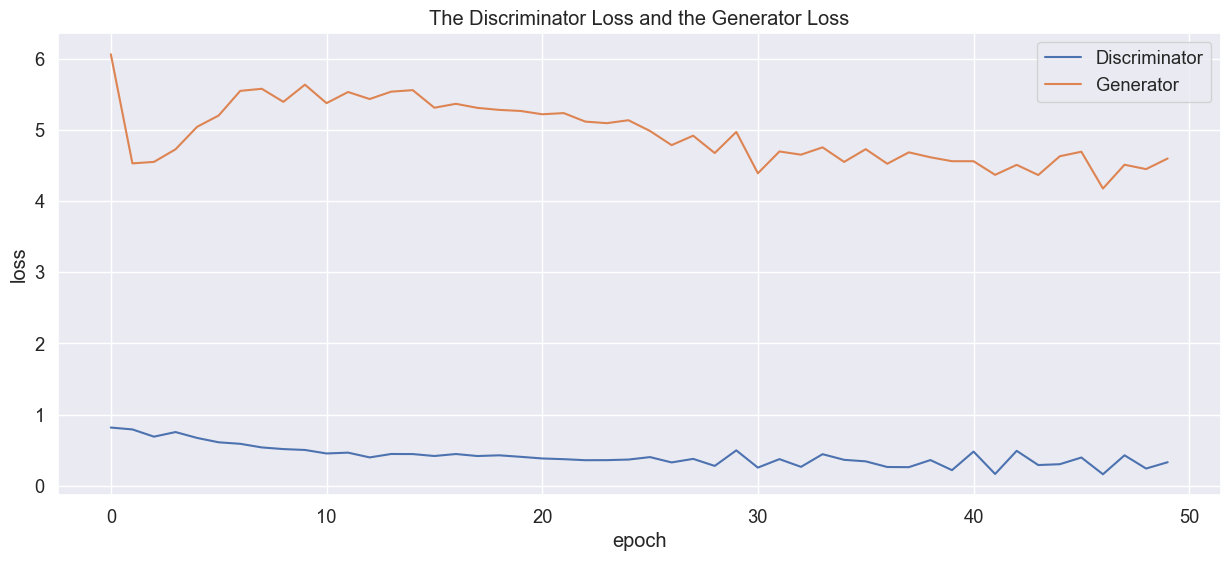

In [119]:
losses_g, losses_d, real_scores, fake_scores = history
plt.figure(figsize=(15,6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('The Discriminator Loss and the Generator Loss');

In this code, I am visualizing the training history of a Generative Adversarial Network (GAN) that I have trained. The training history includes the losses of both the discriminator and the generator over the epochs.

Here's a breakdown of the code:

- `losses_g, losses_d, real_scores, fake_scores = history`: I am unpacking the training history into separate lists for generator losses (`losses_g`), discriminator losses (`losses_d`), real scores (`real_scores`), and fake scores (`fake_scores`).

- `plt.figure(figsize=(15,6))`: I am creating a new figure for the plot with a specified size to ensure clarity and visibility.

- `plt.plot(losses_d, '-')`: I am plotting the discriminator losses over the epochs with a solid line (`'-'`).

- `plt.plot(losses_g, '-')`: I am plotting the generator losses over the epochs with a solid line (`'-'`).

- `plt.xlabel('epoch')`: I am labeling the x-axis as 'epoch' to indicate the horizontal axis represents the number of training epochs.

- `plt.ylabel('loss')`: I am labeling the y-axis as 'loss' to indicate the vertical axis represents the loss values.

- `plt.legend(['Discriminator', 'Generator'])`: I am adding a legend to the plot, specifying that the two lines correspond to the discriminator and generator losses.

- `plt.title('The Discriminator Loss and the Generator Loss')`: I am setting a title for the plot, describing the information it conveys.

This visualization helps me analyze the training process by observing how the losses of the discriminator and generator evolve over the course of training. It can provide insights into the convergence and stability of the GAN model.

## Showing the Generated Images

In [120]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2,1,0]]

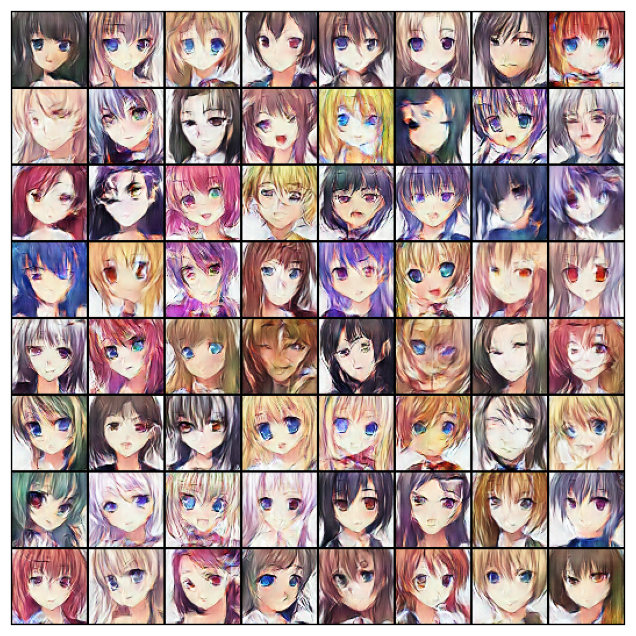

In [124]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img);

In this code, I am loading and displaying a generated image from a GAN training process. Let me break down the code for you:

- `generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')`: I am using OpenCV (`cv2`) to read an image file corresponding to a generated sample. The file name is constructed based on the variable `epochs`, which likely represents the epoch at which the image was generated. The image is loaded into the variable `generated_img`.

- `generated_img = generated_img[:, :, [2,1,0]]`: I am rearranging the color channels of the image. OpenCV loads images in BGR format, and this line swaps the channels to RGB format. The indexing `[2,1,0]` represents the order of channels after the rearrangement.

- `fig, ax = plt.subplots(figsize=(8,8))`: I am creating a new Matplotlib figure (`fig`) and axes (`ax`) for visualization. The `figsize` parameter sets the size of the figure to 8x8 inches.

- `ax.set_xticks([]); ax.set_yticks([])`: I am removing the tick marks on both the x and y axes, providing a cleaner appearance for the image.

- `ax.imshow(generated_img)`: I am displaying the generated image on the axes using the `imshow` function. The image is visualized in the Matplotlib plot.

This code segment allows me to visually inspect a specific generated image from the GAN training process. It's useful for checking the quality and diversity of generated samples at a particular epoch.

## Saving the Generator Model as a .pkl file

In [127]:
generator_model = generator

# Load the generator model in PyTorch
loaded_generator = torch.load('generator_model.pth')

In [128]:
# Serialize the PyTorch generator model using pickle
with open('generator_model.pkl', 'wb') as f:
    pickle.dump(generator_model, f)

# Deserialize the PyTorch generator model using pickle
with open('generator_model.pkl', 'rb') as f:
    loaded_generator = pickle.load(f)